In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
sns.set()

def bold_print(string):
    print('===========================================================================')
    print('===========================================================================')
    print(string)
    print('===========================================================================')
    print('===========================================================================')

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
J_DAYS = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
CITIES = ['מודיעין מכבים רעות', 'באר שבע', 'נתניה']
MODIIN,BEERSHEVA,NETANIA = CITIES

# Loading consumption data, filtering by year

In [2]:
#full_df = pd.read_pickle('full.pkl')
hour_df = pd.read_pickle('hour.pkl')
day_df = pd.read_pickle('day.pkl')
id_df = pd.read_pickle('id.pkl')

In [3]:
hour_df = hour_df[hour_df.year == 2022]
hour_df.head(1)

,total,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,hour,consumption,ts,temperature,r_humidity,heat_index
0,199.341003,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,0,5.037,2022-01-01,10.716666,79.5,10.716667


In [4]:
day_df = day_df.rename(columns={'total':'consumption'})
day_df = day_df[(day_df.year == 2022) & (day_df.city == MODIIN)]
day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts
0,702552276,11,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,199.341003,9.863194,84.395836,9.863194,2022-01-01


In [5]:
id_df.head(1)

,count_reg,no.,city,city_code_HHI,city_code_LAMAS,street,address,lat,lng
id,,,,,,,,,
702552276,11,32,מודיעין מכבים רעות,1932,1200,חרצית,חרצית 32 מודיעין מכבים רעות,31.905869,35.010933


# Loading building metadata from Talia

In [6]:
floors_type_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5:2, 6: 2, 7: 2}
columns_to_rename = {'building_number': 'id', 'DWellTypeC': 'type', 'DWellKomot': 'floors', 'flr_area': 'area', 'STAT_2022': 'stat_area', 'Shape_Area': 'shape_area', 'Shape_Leng': "shape_perimeter"}

stats_df = pd.read_excel('./buildings_in_stats_areas_updated.xlsx')
stats_df_original = pd.read_excel('./buildings_in_stats_areas_updated.xlsx')
stats_df = stats_df.rename(columns=columns_to_rename).drop(['geometry.y', 'floor_class', 'HOUSE_ID2', 'YISHUV_STA', 'status', 'address_new', 'lat', 'lng'], axis=1)
stats_df['floors_type'] = [floors_type_dict.get(x, 3) for x in stats_df.floors]
stats_df['floors_type'] = stats_df.floors_type.astype('category')
stats_df['type'] = stats_df.type.astype('category')

stats_df.head(1)

,id,type,area,floors,stat_area,shape_area,shape_perimeter,floors_type
0,702552276,מגורים,12027.25,16,123,1099.481657,150.003329,3


# Ask Or why floors*shape_area != area

In [7]:
current_length = len(stats_df)
bold_print(f'{current_length} unique ids with polygons in Moddin in 2022')

2475 unique ids with polygons in Moddin in 2022


In [8]:
valid_types = ['מגורים', 'מסחר + מגורים']
stats_df = stats_df[[x in valid_types for x in stats_df.type.values]]
bold_print(f'{current_length - len(stats_df)} commercial/education buildings or without land use type ({len(stats_df)} left)')
current_length = len(stats_df)

stats_df_original.loc[[x not in valid_types for x in stats_df_original.DWellTypeC.values], 'status'] = 'invalid type'

119 commercial/education buildings or without land use type (2356 left)


### Computing compactness

In [64]:
volume = (stats_df.shape_area * stats_df.floors * 3).values
s_min = (np.pi*36*(volume**2))**(1/3)
s = ((stats_df.shape_perimeter * stats_df.floors * 3) + 2*stats_df.shape_area).values
stats_df['compactness'] = s/s_min
stats_df.head(1)

,id,type,area,floors,stat_area,shape_area,shape_perimeter,floors_type,compactness
0,702552276,מגורים,12027.25,16,123,1099.481657,150.003329,3,1.381392


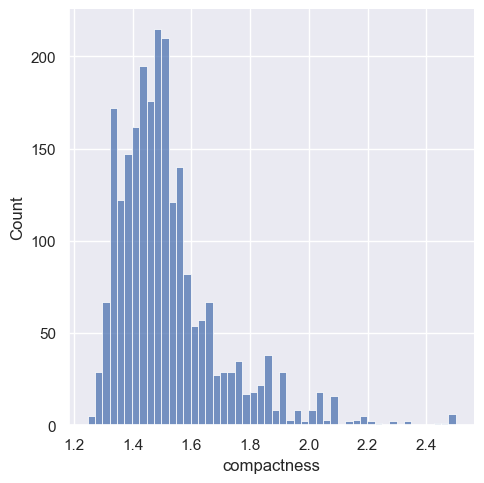

In [65]:
sns.displot(stats_df.compactness)

### Joining stats data to hour/day dataframes

In [9]:
day_df = day_df.set_index('id').join(stats_df.set_index('id')).reset_index()
hour_df = hour_df.set_index('id').join(stats_df.set_index('id')).reset_index()
id_df = id_df.join(stats_df.set_index('id'))
day_df = day_df[~day_df.area.isna()]
hour_df = hour_df[~hour_df.area.isna()]
day_df.id.nunique()

2356

# Filtering Data:

In [10]:
gr = day_df[(day_df.month >=4) & (day_df.month <=9)].groupby('id').count().reset_index()
other_ids = set(day_df.id.unique()) - set(gr.id.unique())
not_full_period_ids = set(gr[gr.count_reg < 183].id).union(other_ids)

day_df = day_df[day_df.id.map(lambda x: x not in not_full_period_ids)]
bold_print(f'{current_length - day_df.id.nunique()} without daily data in April - September ({day_df.id.nunique()} left)')
current_length = day_df.id.nunique()

stats_df_original.loc[[x in not_full_period_ids for x in stats_df_original.building_number.values], 'status'] = 'lack of data'

168 without daily data in April - September (2188 left)


[(-2.0, 0.0)]

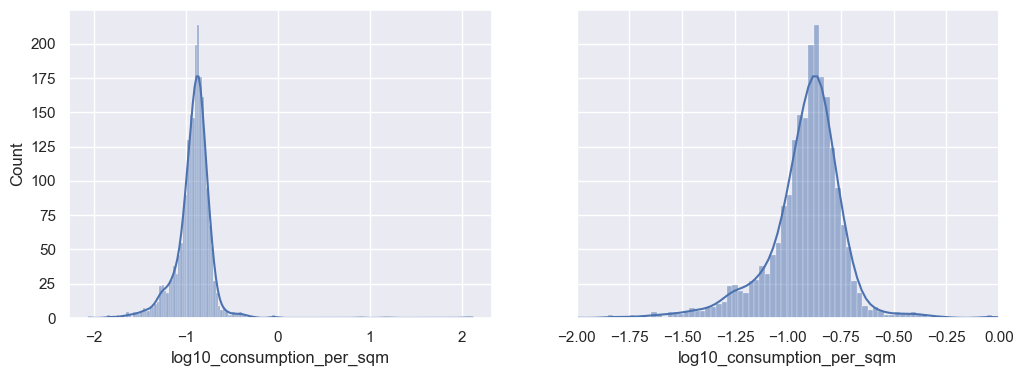

In [11]:
day_df['consumption_per_sqm'] = day_df.consumption / day_df.area
gr = day_df.groupby('id').mean(numeric_only=True).reset_index()
gr['log10_consumption_per_sqm'] = np.log10(gr.consumption_per_sqm)
_, ax = plt.subplots(1,2, sharey=True, figsize=(12,4))
sns.histplot(gr.log10_consumption_per_sqm, ax=ax[0], kde=True)
p = sns.histplot(gr.log10_consumption_per_sqm,  ax=ax[1], kde=True)
p.set(xlim=(-2, 0))

In [12]:
overconsuming = gr[gr.log10_consumption_per_sqm > -0.25].id.unique()
underconsuming = gr[gr.log10_consumption_per_sqm < -1.75].id.unique()
overconsuming_one_time = [x for x in day_df[day_df.consumption_per_sqm > 3].id.unique() if x not in overconsuming]
day_df = day_df[day_df.id.map(lambda x: x not in overconsuming and x not in underconsuming and x not in overconsuming_one_time)]
current_length = day_df.id.nunique()

bold_print(f'Overconsuming: {len(overconsuming)}, Underconsuming: {len(underconsuming)}, Overconsuming one day: {len(overconsuming_one_time)}. {current_length} left')

stats_df_original.loc[[x in overconsuming for x in stats_df_original.building_number.values], 'status'] = 'overconsuming'
stats_df_original.loc[[x in underconsuming for x in stats_df_original.building_number.values], 'status'] = 'underconsuming'
stats_df_original.loc[[x in overconsuming_one_time for x in stats_df_original.building_number.values], 'status'] = 'overconsuming one day'

Overconsuming: 7, Underconsuming: 4, Overconsuming one day: 4. 2173 left


### Save original excel file with updated statuses. Apply filtering to hour_df.

In [13]:
stats_df_original.to_excel('./buildings_in_stats_areas_updated2.xlsx', index=False)
Counter(stats_df_original.status)

Counter({'underconsuming': 4,
         'valid': 2173,
         'invalid type': 119,
         'lack of data': 168,
         'overconsuming': 7,
         'overconsuming one day': 4})

In [17]:
valid_ids = set(day_df.id.unique())
hour_df = hour_df[(hour_df.id.map(lambda x: x in valid_ids)) & (hour_df.year == 2022)]
hour_df['consumption_per_sqm'] = hour_df.consumption / hour_df.area

# Basic viz

In [18]:
def radar_plt(stats, ax, title, labels=None):
    if labels is None:
        labels = np.arange(1, len(stats)+1)
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)[::-1] # Set the angle
    stats=np.concatenate((stats,[stats[0]]))  # Closed
    angles=np.concatenate((angles,[angles[0]]))  # Closed
    ax.plot(angles, stats, 'o-', linewidth=2)  # Draw the plot (or the frame on the radar chart)
    ax.fill(angles, stats, alpha=0.25)  #Fulfill the area
    ax.set_thetagrids(angles * 180/np.pi, np.concatenate((labels, labels[:1])))  # Set the label for each axis
    ax.set_title(title)  # Set the pokemon's name as the title
    #ax.set_rlim(0,250)
    ax.grid(True)

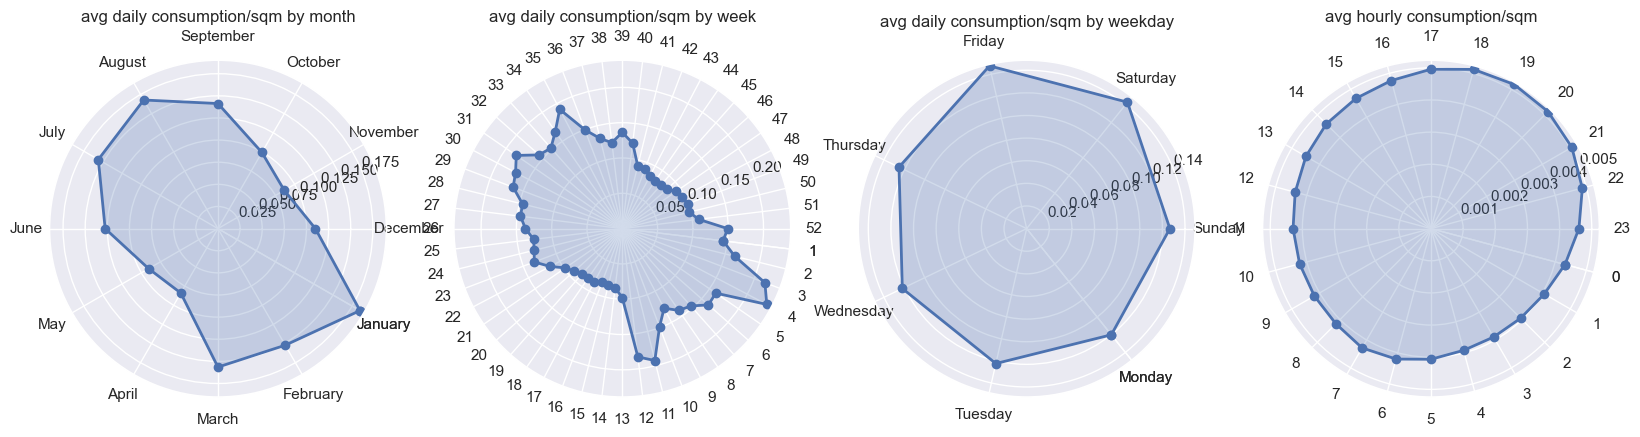

In [19]:
fig, axs = plt.subplots(figsize=(20, 5), nrows=1, ncols=4,
                            subplot_kw=dict(projection='polar'))
stats=day_df.groupby('month').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[0], 'avg daily consumption/sqm by month', MONTHS)
stats=day_df.groupby('week').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[1], 'avg daily consumption/sqm by week')
stats=day_df.groupby('weekday').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[2], 'avg daily consumption/sqm by weekday', DAYS)
stats=hour_df.groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[3], 'avg hourly consumption/sqm', np.arange(0,24))

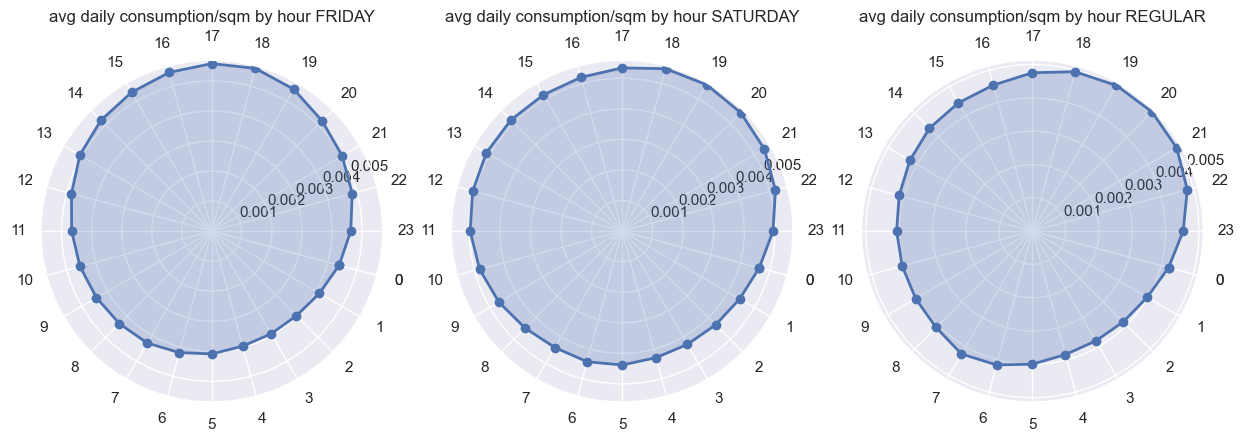

In [20]:
fig, axs = plt.subplots(figsize=(15, 5), nrows=1, ncols=3, subplot_kw=dict(projection='polar'))
stats=hour_df[(hour_df.weekday == 4)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[0], f'avg daily consumption/sqm by hour FRIDAY', np.arange(0,24))
stats=hour_df[(hour_df.weekday == 5)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[1], f'avg daily consumption/sqm by hour SATURDAY', np.arange(0,24))
stats=hour_df[(hour_df.weekday != 4) & (hour_df.weekday != 5)].groupby('hour').mean(numeric_only=True).consumption_per_sqm.values
radar_plt(stats, axs[2], f'avg daily consumption/sqm by hour REGULAR', np.arange(0,24))

[Text(0.5, 1.0, 'consumption_per_sqm during the cold season')]

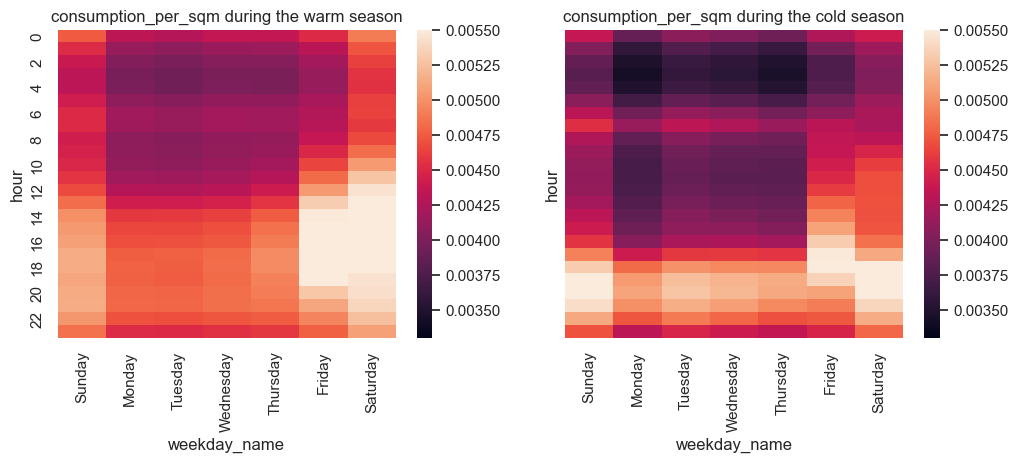

In [21]:
_, ax = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
table = hour_df[(hour_df.month >=4) & (hour_df.month <= 9)].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption_per_sqm')
p = sns.heatmap(table, ax=ax[0], vmin=0.0033, vmax=0.0055)
p.set(title='consumption_per_sqm during the warm season')
table = hour_df[(hour_df.month <4) | (hour_df.month > 9)].groupby(['weekday_name', 'hour']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='weekday_name', index='hour', values='consumption_per_sqm')
sns.heatmap(table, ax=ax[1], vmin=0.0033, vmax=0.0055).set(title='consumption_per_sqm during the cold season')

[Text(0.5, 1.0, 'consumption_per_sqm')]

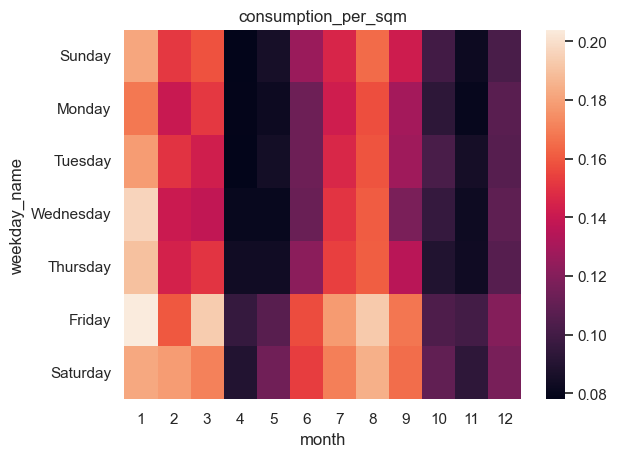

In [22]:
table = day_df.groupby(['weekday_name', 'month']).mean(numeric_only=True)['consumption_per_sqm'].reset_index().pivot(columns='month', index='weekday_name', values='consumption_per_sqm')
sns.heatmap(table).set(title='consumption_per_sqm')

<Axes: xlabel='floors', ylabel='area'>

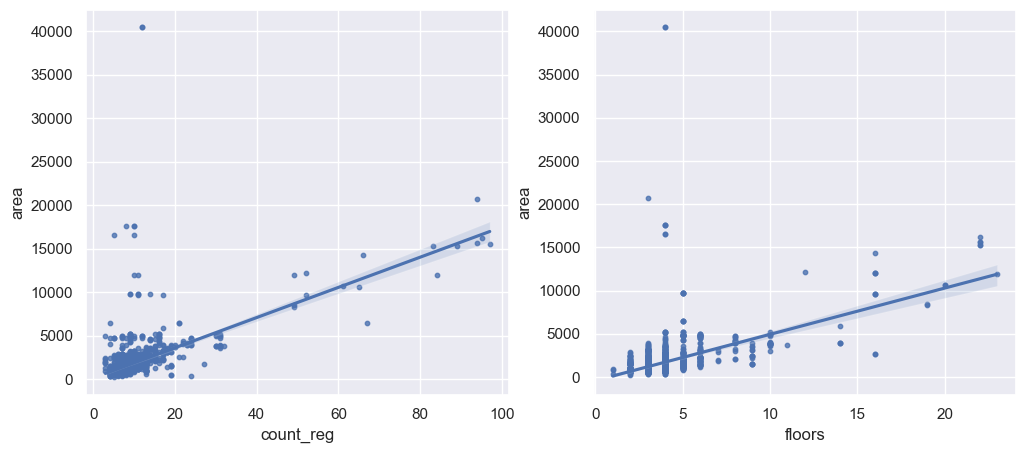

In [23]:
_, ax = plt.subplots(1,2, figsize=(12,5))
sns.regplot(x='count_reg', y='area', data=id_df[id_df.area > 0], scatter_kws={'s':10}, ax=ax[0])
sns.regplot(x='floors', y='area', data=id_df[id_df.floors > 0], scatter_kws={'s':10}, ax=ax[1])

<Axes: xlabel='floors', ylabel='consumption'>

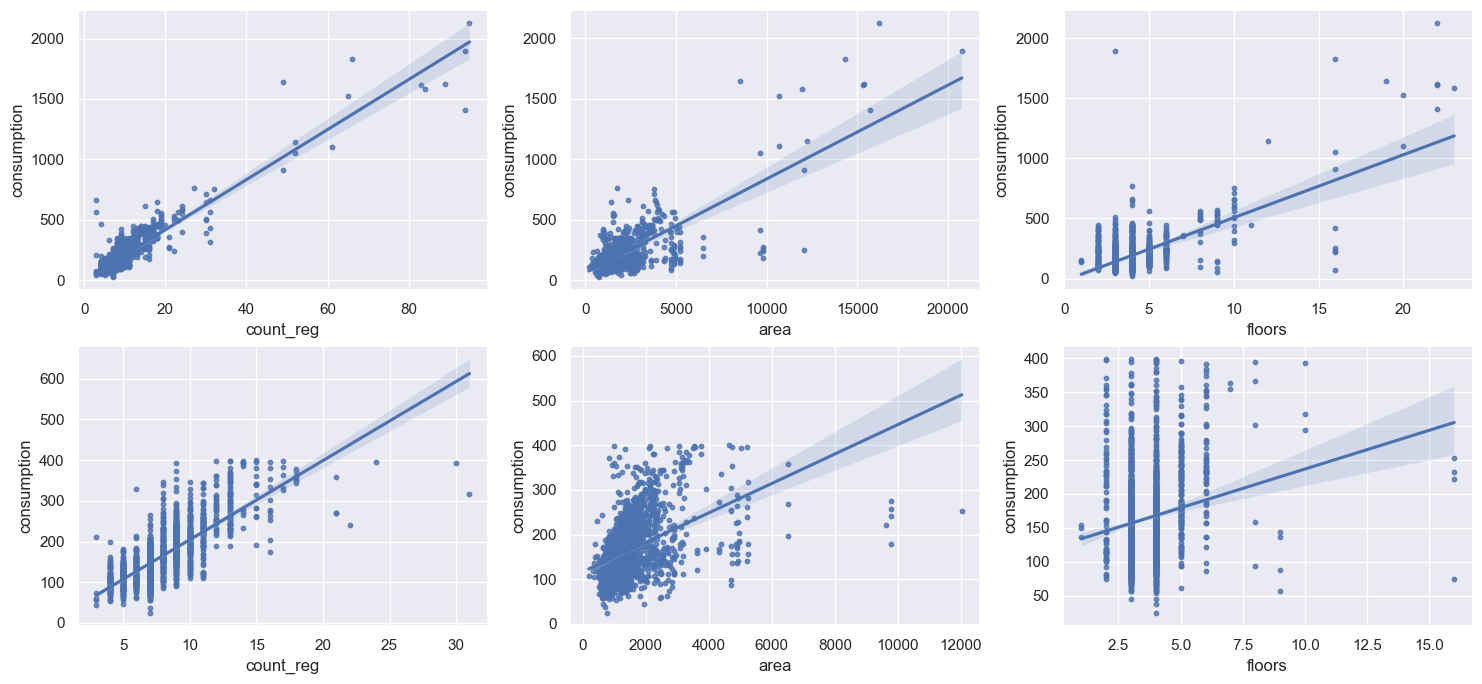

In [24]:
gr = day_df.groupby(['id']).mean(numeric_only=True)
_, ax = plt.subplots(2,3, figsize=(18,8))
sns.regplot(data=gr, x='count_reg', y='consumption', ax=ax[0][0], scatter_kws={'s':10})
sns.regplot(data=gr, x='area', y='consumption',ax=ax[0][1], scatter_kws={'s':10})
sns.regplot(data=gr, x='floors', y='consumption',ax=ax[0][2], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='count_reg', y='consumption', ax=ax[1][0], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='area', y='consumption',ax=ax[1][1], scatter_kws={'s':10})
sns.regplot(data=gr[gr.consumption < 400], x='floors', y='consumption',ax=ax[1][2], scatter_kws={'s':10})

# Consumption analysis

In [30]:
h_df = pd.DataFrame(hour_df)
day_mapping = {i: 'regular' for i in range(7)}
day_mapping[4] = 'friday'
day_mapping[5] = 'saturday'
h_df['day_type'] = hour_df.weekday.map(lambda x: day_mapping[x])
h_df = h_df.drop(['city', 'month', 'day', 'weekday_name', 'week', 'weekday', 'day_of_year', 'year', 'total', 'temperature', 'r_humidity'], axis=1)
h_df.head(1)

,id,count_reg,hour,consumption,ts,heat_index,type,area,floors,stat_area,shape_area,shape_perimeter,floors_type,consumption_per_sqm,day_type
8712,702552288,10,0,11.122999,2022-01-01,10.716667,מגורים,12027.25,16.0,123.0,1099.481657,150.003329,3.0,0.000925,saturday


### Compute normalized consumption per sqm w.r.t average/20th quantile for the same id, day type and hour

In [31]:
%%time
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

agg_dict = h_df[['id', 'day_type', 'hour', 'consumption_per_sqm']].groupby(['id', 'day_type', 'hour']).agg(
    mean_consumption=('consumption_per_sqm', np.mean), 
    q_consumption=('consumption_per_sqm', percentile(0.2))
).to_dict()

results = []
for x in h_df[['id', 'day_type', 'hour', 'consumption_per_sqm']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[3])/agg_dict[name][x[0], x[1], x[2]])
    results.append(row)
h_df[['normalized_consumption_sqm_day_hour', 'normalized_q_consumption_sqm_day_hour']] = results
h_df.head(1)

CPU times: total: 16.6 s
Wall time: 1min 19s


,id,count_reg,hour,consumption,ts,heat_index,type,area,floors,stat_area,shape_area,shape_perimeter,floors_type,consumption_per_sqm,day_type,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour
8712,702552288,10,0,11.122999,2022-01-01,10.716667,מגורים,12027.25,16.0,123.0,1099.481657,150.003329,3.0,0.000925,saturday,95.478089,141.636519


### Compute normalized consumption per sqm w.r.t average/20th quantile for the same id

In [32]:
%%time
agg_dict = h_df[['id','consumption_per_sqm']].groupby(['id']).agg(
    mean_consumption=('consumption_per_sqm', np.mean), 
    q_consumption=('consumption_per_sqm', percentile(0.2))
).to_dict()

results = []
for x in h_df[['id', 'consumption_per_sqm']].values:
    row = []
    for name in ['mean_consumption', 'q_consumption']:
        row.append(100*(x[1])/agg_dict[name][x[0]])
    results.append(row)
h_df[['normalized_consumption_sqm', 'normalized_q_consumption_sqm']] = results
h_df.head(1)

CPU times: total: 3.45 s
Wall time: 31.7 s


,id,count_reg,hour,consumption,ts,heat_index,type,area,floors,stat_area,shape_area,shape_perimeter,floors_type,consumption_per_sqm,day_type,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour,normalized_consumption_sqm,normalized_q_consumption_sqm
8712,702552288,10,0,11.122999,2022-01-01,10.716667,מגורים,12027.25,16.0,123.0,1099.481657,150.003329,3.0,0.000925,saturday,95.478089,141.636519,108.318671,152.746486


In [33]:
h_df['r_heat_index'] = np.round(h_df.heat_index).astype('int')
h_df = h_df[(h_df.ts.dt.month >= 4) & (h_df.ts.dt.month <= 9)]

[Text(0.5, 1.0, 'MODIIN regular days April-Sept. Normalized consumption/sqm (w.r.t. 20th quantile for this building/day type/hour)')]

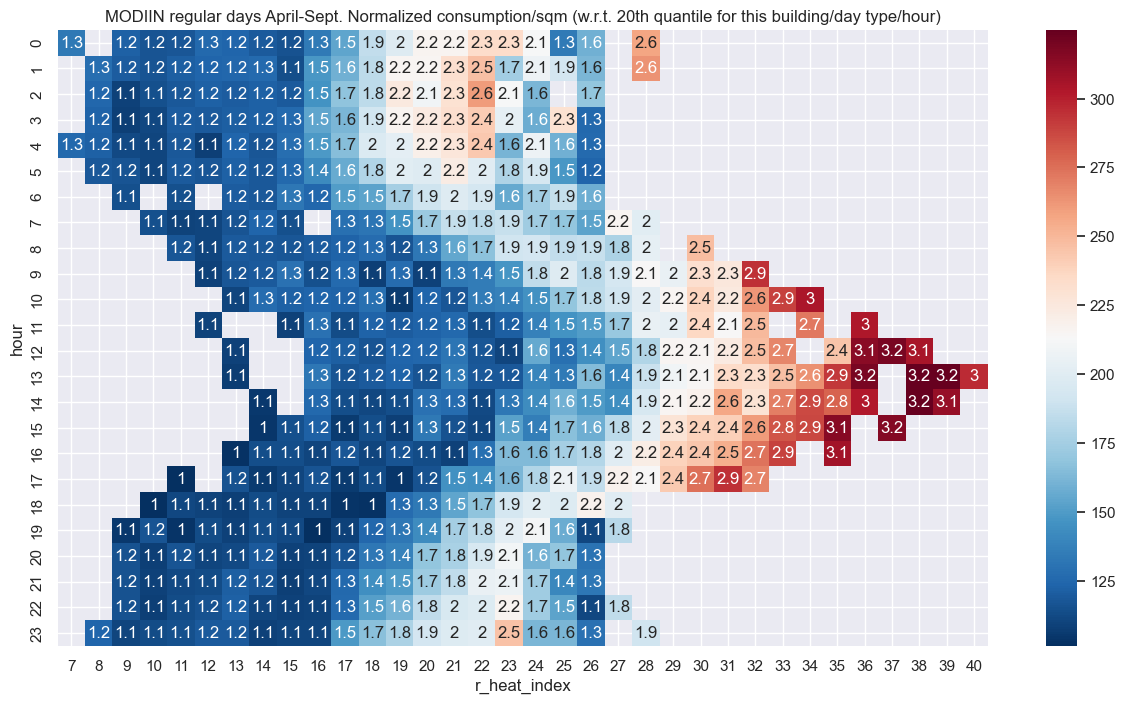

In [34]:
day_type = 'regular'
table = h_df[['hour', 'normalized_q_consumption_sqm_day_hour', 'r_heat_index']].groupby(['r_heat_index', 'hour']).mean().reset_index().pivot(columns='r_heat_index', index='hour', values='normalized_q_consumption_sqm_day_hour')
plt.figure(figsize=(15,8))
sns.heatmap(table, annot=np.round(table.values/100, 1), cmap='RdBu_r').set(title=f'MODIIN {day_type} days April-Sept. Normalized consumption/sqm (w.r.t. 20th quantile for this building/day type/hour)')

### Compute moving averages of temperature

In [38]:
doy_weather_df = pd.read_pickle('weather.pkl').reset_index(drop=True)
doy_weather_df = doy_weather_df[(doy_weather_df.city == MODIIN) & (doy_weather_df.ts.dt.year == 2022)]
doy_weather_df = doy_weather_df.groupby(doy_weather_df.ts.dt.day_of_year).mean(numeric_only=True)
d = doy_weather_df.to_dict()['heat_index']
daily_temps = np.array([d[i] for i in range(1,366)])

In [42]:
h_df['mean_hi'] = h_df.ts.map(lambda x: daily_temps[x.day_of_year - 1])
for ws in [3,5,7]:
    mean_temps = [daily_temps[0]] + [daily_temps[max(0, i-ws):i].mean() for i in range(1, len(daily_temps))]
    h_df[f'{ws}ma_hi'] = h_df.ts.map(lambda x: mean_temps[x.day_of_year - 1])

h_df.head(1)

,id,count_reg,hour,consumption,ts,heat_index,type,area,floors,stat_area,...,day_type,normalized_consumption_sqm_day_hour,normalized_q_consumption_sqm_day_hour,normalized_consumption_sqm,normalized_q_consumption_sqm,r_heat_index,mean_hi,3ma_hi,5ma_hi,7ma_hi
8801,702552288,10,0,8.884,2022-04-01,20.316667,מגורים,12027.25,16.0,123.0,...,friday,81.1461,118.563987,86.514711,121.999447,20,23.404108,16.324074,14.089222,12.07881


<Axes: xlabel='3ma_hi', ylabel='heat_index'>

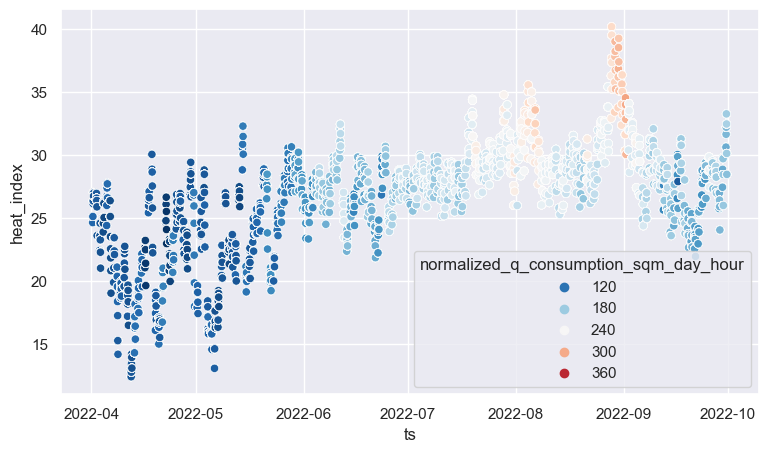

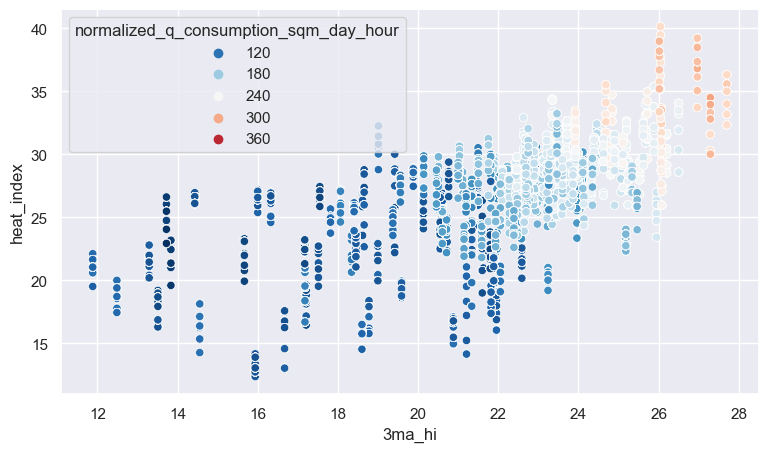

In [44]:
gr = h_df.groupby(['ts','hour', 'stat_area']).mean(numeric_only=True).reset_index()
plt.figure(figsize=(9,5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 17)], x='ts', y='heat_index', hue='normalized_q_consumption_sqm_day_hour', palette='RdBu_r')
plt.figure(figsize=(9, 5))
sns.scatterplot(data=gr[(gr.hour >= 10) & (gr.hour < 17)], x='3ma_hi', y='heat_index', hue='normalized_q_consumption_sqm_day_hour', palette='RdBu_r')

### Effect of compactness on consumption

In [ ]:
volume = 

### Effect of stat areas on consumption

<Axes: xlabel='ts', ylabel='normalized_q_consumption_sqm'>

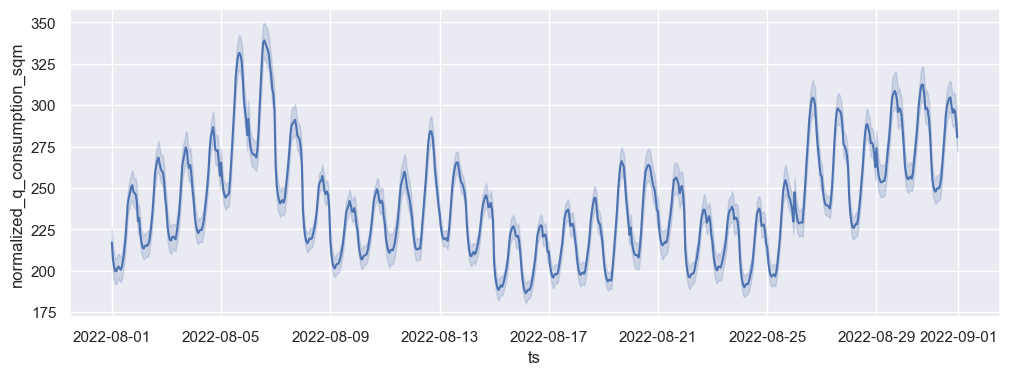

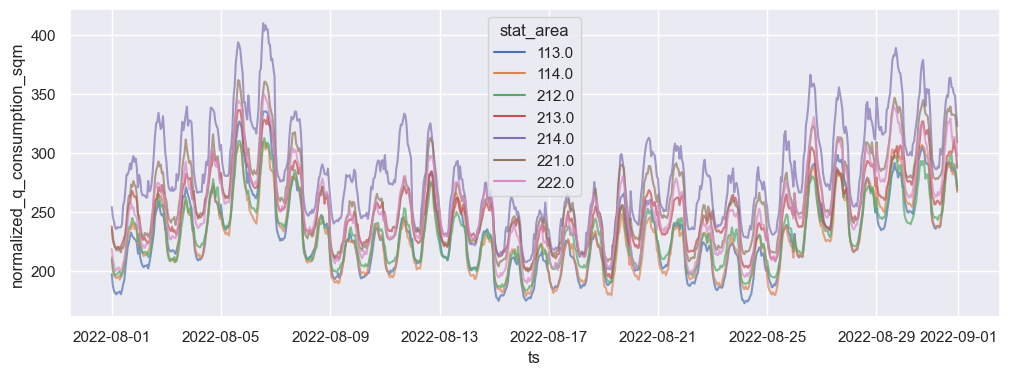

In [45]:
c = Counter(id_df[id_df.area > 0].stat_area)
good = sorted([k for k, v in c.items() if v > 130])

gr['stat_area'] = gr["stat_area"].astype('category')
plt.figure(figsize=(12,4))
sns.lineplot(data=gr[gr.ts.dt.month == 8], x='ts', y='normalized_q_consumption_sqm')

plt.figure(figsize=(12,4))
sns.lineplot(data=gr[gr.ts.dt.month == 8], x='ts', y='normalized_q_consumption_sqm', hue='stat_area', hue_order=good, alpha=0.7)

### Effect of number of floors on consumption

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_24472\2257992110.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gr = h_df.groupby(['ts', 'floors_type']).mean().reset_index()


<Axes: xlabel='ts', ylabel='normalized_q_consumption_sqm'>

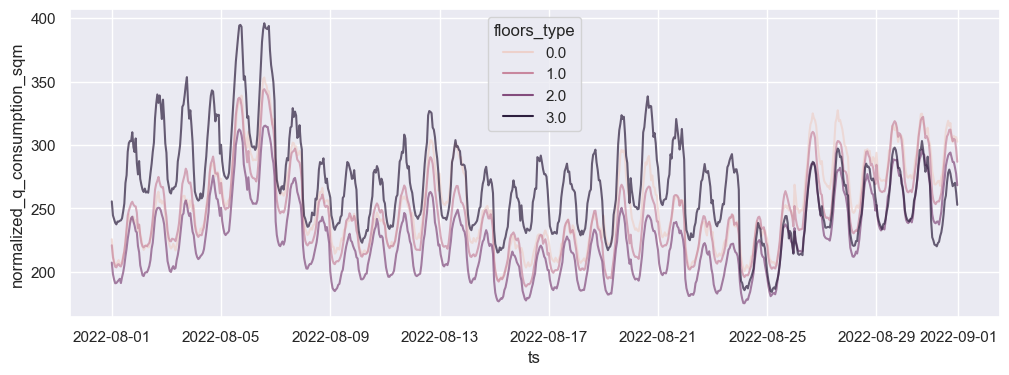

In [48]:
gr = h_df.groupby(['ts', 'floors_type']).mean().reset_index()
plt.figure(figsize=(12,4))
sns.lineplot(data=gr[gr.ts.dt.month == 8], x='ts', y='normalized_q_consumption_sqm', hue='floors_type',alpha=0.7)

In [107]:
city level
floors/compactness
stat areas

C:\Users\Chapanin\AppData\Local\Temp\ipykernel_16672\2982821506.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Counter(day_df.groupby('id').mean().floors)


Counter({16.0: 8,
         4.0: 853,
         3.0: 953,
         5.0: 162,
         9.0: 14,
         2.0: 82,
         6.0: 60,
         8.0: 12,
         19.0: 1,
         10.0: 14,
         20.0: 2,
         22.0: 4,
         12.0: 1,
         1.0: 3,
         11.0: 1,
         7.0: 2,
         23.0: 1})

In [38]:
h_df.columns

Index(['id', 'total', 'count_reg', 'city', 'month', 'day', 'weekday',
       'weekday_name', 'day_of_year', 'week', 'year', 'hour', 'consumption',
       'ts', 'temperature', 'r_humidity', 'heat_index', 'area', 'type',
       'floors', 'stat_area', 'consumption_per_sqm', 'day_type',
       'normalized_consumption_sqm_day_hour',
       'normalized_q_consumption_sqm_day_hour', 'normalized_consumption_sqm',
       'normalized_q_consumption_sqm', 'r_heat_index', 'mean_hi', '3ma_hi',
       '5ma_hi', '7ma_hi', '10ma_hi'],
      dtype='object')

In [ ]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
CUTOFF = 20
data = h_df[(h_df.hour > 16) & (h_df.hour < 20)][['heat_index', '5ma_hi', '3ma_hi', '7ma_hi', 'normalized_q_consumption_sqm_day_hour', 'normalized_q_consumption_sqm', 'ts', 'area', 'floors', 'stat_area']]
data['shifted_hi'] = np.clip(data.heat_index - CUTOFF, 0, None)
data['shifted_5ma_hi'] = np.clip(data['5ma_hi'] - CUTOFF, 0, None)
data['shifted_3ma_hi'] = np.clip(data['3ma_hi'] - CUTOFF, 0, None)
data['shifted_7ma_hi'] = np.clip(data['7ma_hi'] - CUTOFF, 0, None)
data.head(1)

,heat_index,5ma_hi,3ma_hi,7ma_hi,normalized_q_consumption_sqm_day_hour,normalized_q_consumption_sqm,ts,area,floors,stat_area,shifted_hi,shifted_5ma_hi,shifted_3ma_hi,shifted_7ma_hi
14989,25.733333,14.089222,16.324074,12.07881,114.936451,131.392471,2022-04-01 17:00:00,12027.25,16.0,123.0,5.733333,0.0,0.0,0.0


In [42]:
enc = OneHotEncoder(handle_unknown='ignore')

Feature importances: HEAT_INDEX - 5.58, 7DAY_AVG - 20.91, AREA - 0.0004, FLOORS - 0.61, STAT AREA (MEAN ABS VALUE) - 7.39
R coef: 0.11727918306213814
MSE: 16982.936736490126


Text(0.5, 1.0, 'Real (red) vs predicted (blue) consumption change between 11 and 16')

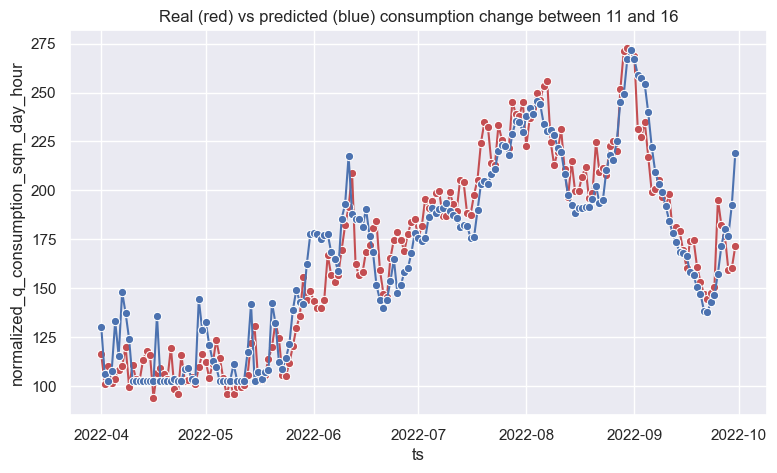

In [43]:
y = data.normalized_q_consumption_sqm_day_hour
X = np.array(data[['shifted_hi', 'shifted_7ma_hi', 'area', 'floors']])
encoded = enc.fit_transform(data[['stat_area']]).todense().A
X = np.concatenate([X,encoded], axis=1)
regr = linear_model.LinearRegression()
regr.fit(X, y)
preds = regr.predict(X)
data['preds'] = preds
print(f'Feature importances: HEAT_INDEX - {regr.coef_[0]:.2f}, 7DAY_AVG - {regr.coef_[1]:.2f}, AREA - {regr.coef_[2]:.4f}, FLOORS - {regr.coef_[3]:.2f}, STAT AREA (MEAN ABS VALUE) - {np.mean(np.abs(regr.coef_)[4:]):.2f}')
print(f'R coef: {regr.score(X, y)}')
print(f'MSE: {mean_squared_error(y, preds)}')
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr, x='ts', y='normalized_q_consumption_sqm_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr, x='ts', y='preds', color='b', marker='o')
f.set_title('Real (red) vs predicted (blue) consumption change between 11 and 16')

Text(0.5, 1.0, 'Real (red) vs predicted (blue) consumption change between 11 and 16 when trained till 1.08')

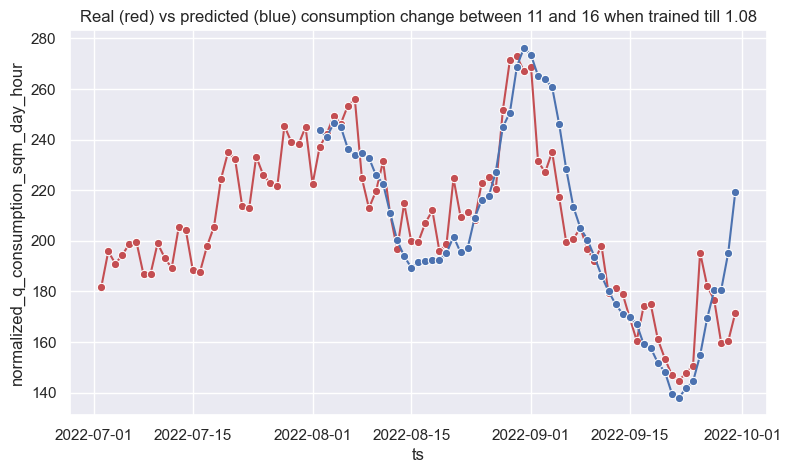

In [44]:
y = data[data.ts < pd.Timestamp('2022-08-01')].normalized_q_consumption_sqm_day_hour
X = np.array(data[data.ts < pd.Timestamp('2022-08-01')][['shifted_hi', 'shifted_7ma_hi', 'area', 'floors']])
encoded_small = enc.fit_transform(data[data.ts < pd.Timestamp('2022-08-01')][['stat_area']]).todense().A
X = np.concatenate([X,encoded_small], axis=1)
regr = linear_model.LinearRegression()
regr.fit(X, y)
data['preds'] = regr.predict(np.concatenate([data[['shifted_hi', 'shifted_7ma_hi', 'area', 'floors']],encoded], axis=1))
plt.figure(figsize=(9, 5))
gr = data.groupby(data.ts.dt.floor('D')).mean(numeric_only=True).reset_index()
sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-07-01')], x='ts', y='normalized_q_consumption_sqm_day_hour', color='r', marker='o')
f = sns.lineplot(data=gr[gr.ts > pd.Timestamp('2022-08-01')], x='ts', y='preds', color='b', marker='o')
f.set_title('Real (red) vs predicted (blue) consumption change between 11 and 16 when trained till 1.08')

In [ ]:
9-13, 
14-17,
18-21,
22-01,
02-08

## Time series prediction attemps

In [95]:
import geopandas
from geodatasets import get_path

path_to_data = get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

Extracting 'nybb_16a/nybb.shp' from 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip' to 'C:\Users\Chapanin\AppData\Local\geodatasets\geodatasets\Cache\nybb_16a.zip.unzip'


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,type,floors,stat_area,consumption_per_sqm
363,702552288,10,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,324.125000,9.863194,84.395836,9.863194,2022-01-01,12027.25,מגורים,16.0,123.0,0.026949
364,702552288,10,מודיעין מכבים רעות,1,2,6,Sunday,2,52,2022,256.738007,10.308333,85.555550,10.308333,2022-01-02,12027.25,מגורים,16.0,123.0,0.021346
365,702552288,10,מודיעין מכבים רעות,1,3,0,Monday,3,1,2022,220.684006,9.485416,89.069450,9.485417,2022-01-03,12027.25,מגורים,16.0,123.0,0.018349
366,702552288,10,מודיעין מכבים רעות,1,4,1,Tuesday,4,1,2022,293.549011,9.476389,85.104164,9.476389,2022-01-04,12027.25,מגורים,16.0,123.0,0.024407
367,702552288,10,מודיעין מכבים רעות,1,5,2,Wednesday,5,1,2022,203.642014,10.593750,83.000000,10.593750,2022-01-05,12027.25,מגורים,16.0,123.0,0.016932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889987,704550861,13,מודיעין מכבים רעות,12,27,1,Tuesday,361,52,2022,369.799957,8.507639,87.729164,8.507639,2022-12-27,2340.75,מגורים,4.0,313.0,0.157984
889988,704550861,13,מודיעין מכבים רעות,12,28,2,Wednesday,362,52,2022,343.996979,9.615973,86.847221,9.615972,2022-12-28,2340.75,מגורים,4.0,313.0,0.146960
889989,704550861,13,מודיעין מכבים רעות,12,29,3,Thursday,363,52,2022,335.315002,10.379861,74.881943,10.379861,2022-12-29,2340.75,מגורים,4.0,313.0,0.143251
889990,704550861,13,מודיעין מכבים רעות,12,30,4,Friday,364,52,2022,361.131989,9.918056,69.916664,9.918056,2022-12-30,2340.75,מגורים,4.0,313.0,0.154280


In [ ]:
list(c(201160.2188, 201169.8594, 201172.8658, 201175.8018, 201178.6639, 201181.4487, 201184.1531, 201186.7737, 201189.3077, 201191.752, 201194.1038, 201196.3603, 201198.5188, 201200.577, 201202.5323, 201204.3824, 201206.1253, 201207.7589, 201209.2813, 201191.0156, 201189.8149, 201188.5292, 201187.1601, 201185.7089, 201184.1773, 201182.567, 201180.8797, 201179.1172, 201177.2816, 201175.3748, 201173.3989, 201171.3561, 201169.2485, 201167.0786, 201164.8487, 201162.5613, 201160.2188, 645997.843800001, 
646015.4375, 646013.4267, 646011.3144, 646009.103, 646006.7951, 646004.393300001, 646001.900599999, 645999.319700001, 645996.6537, 645993.9058, 645991.0791, 645988.176999999, 645985.2028, 645982.16, 645979.052100001, 645975.8829, 645972.6559, 645969.375, 645961.25, 645963.8356, 645966.380000001, 645968.8804, 645971.3342, 645973.738600001, 645976.091, 645978.388800001, 645980.6295, 645982.8106, 645984.9298, 645986.9847, 645988.973099999, 645990.8928, 645992.741699999, 645994.5178, 645996.2191, 645997.843800001
))

# Or's request

In [46]:
#doi = 240-242 #160-162
#241 161 +-1
day_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm
443,702552288,10,מודיעין מכבים רעות,1,1,5,Saturday,1,52,2022,324.125,9.863194,84.395836,9.863194,2022-01-01,12027.25,0.026949


In [66]:
s1 = set(day_df[(day_df.ts.dt.month >= 4) & (day_df.ts.dt.month <= 9)].id.unique())
s2 = set(day_df.id.unique())
s2 - s1

{702553216,
 702553222,
 702553237,
 702553619,
 702568814,
 702583438,
 702583449,
 704184425,
 704190485,
 704193250,
 704194756,
 704196227,
 704198869}

In [69]:
gr = day_df[(day_df.month >=4) & (day_df.month <=9)].groupby('id').count().reset_index()
gr[gr.id == 702553216]

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm


In [47]:
d_df = pd.DataFrame(day_df[(day_df.ts.dt.month >= 4) & (day_df.ts.dt.month <= 9)])
day_mapping = {i: 'regular' for i in range(7)}
day_mapping[4] = 'friday'
day_mapping[5] = 'saturday'
d_df['day_type'] = d_df.ts.dt.weekday.map(lambda x: day_mapping[x])
d_df.head(1)

,id,count_reg,city,month,day,weekday,weekday_name,day_of_year,week,year,consumption,temperature,r_humidity,heat_index,ts,area,consumption_per_sqm,day_type
576,702552288,10,מודיעין מכבים רעות,4,1,4,Friday,91,13,2022,228.871994,23.597916,20.590277,23.404108,2022-04-01,12027.25,0.019029,friday


In [53]:
means = (d_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

In [54]:
doy = 161
tmp_df = d_df[((d_df.ts.dt.day_of_year < doy-1) | (d_df.ts.dt.day_of_year > doy+1)) & (d_df.day_type == 'regular') & (d_df.month == 6)]
means_june = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

tmp_df = d_df[(d_df.ts.dt.day_of_year >= doy-1) & (d_df.ts.dt.day_of_year <= doy+1)]
means_june_hw = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

In [57]:
doy = 241
tmp_df = d_df[((d_df.ts.dt.day_of_year < doy-1) | (d_df.ts.dt.day_of_year > doy+1)) & (d_df.day_type == 'regular') & (d_df.month == 8)]
means_aug = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

tmp_df = d_df[(d_df.ts.dt.day_of_year >= doy-1) & (d_df.ts.dt.day_of_year <= doy+1)]
means_aug_hw = (tmp_df[['id', 'consumption_per_sqm']].groupby('id').mean()).to_dict()['consumption_per_sqm']

In [58]:
len(means), len(means_june), len(means_june_hw), len(means_aug), len(means_aug_hw)

(1982, 1982, 1982, 1982, 1982)

In [61]:
result_df = day_df[['id', 'city', 'count_reg']].drop_duplicates()
ids = list(result_df.id.unique())
result_df['mean_consumption'] = [means.get(x, np.nan) for x in ids]
result_df['june_week_before'] = [means_june.get(x, np.nan) for x in ids]
result_df['june_heatwave'] = [means_june_hw.get(x, np.nan) for x in ids]
result_df['aug_week_before'] = [means_aug.get(x, np.nan) for x in ids]
result_df['aug_heatwave'] = [means_aug_hw.get(x, np.nan) for x in ids]
result_df = result_df[~result_df.isna().any(axis=1)]
result_df.head(5)

,id,city,count_reg,mean_consumption,june_week_before,june_heatwave,aug_week_before,aug_heatwave
0,702552276,מודיעין מכבים רעות,11,175.972794,148.952408,240.212662,253.524612,331.006683
443,702552288,מודיעין מכבים רעות,10,258.879395,225.950394,312.330688,321.059814,329.205658
1301,702552351,מודיעין מכבים רעות,9,159.139755,165.712006,221.489014,172.667801,253.122681
1731,702552359,מודיעין מכבים רעות,7,161.700516,151.406601,216.144669,178.477386,240.525009
2159,702552363,מודיעין מכבים רעות,7,115.805008,100.506607,158.507675,150.108994,174.927322


In [71]:
import torch
torch.__version__

'2.0.1'

In [62]:
result_df.to_csv('consumption_modiin_netanya_bs.csv')
result_df[result_df.city == BEERSHEVA].to_csv('consumption_bs.csv')

In [63]:
flat_df = result_df.melt(id_vars = ['id', 'city', 'count_reg'], value_name = 'consumption', var_name = 'consumption_type')
flat_df['consumption_per_counter'] = flat_df.consumption / flat_df.count_reg
flat_df.head(1)

,id,city,count_reg,consumption_type,consumption,consumption_per_counter
0,702552276,מודיעין מכבים רעות,11,mean_consumption,175.972794,15.997527


In [67]:
gr = flat_df.groupby('id').max().reset_index()
bad_ids = set(gr[(gr.consumption_per_counter > 70) | (gr.consumption_per_counter < 5)].id.values)
flat_df = flat_df[flat_df.id.map(lambda x: x not in bad_ids)]
result_df = result_df[result_df.id.map(lambda x: x not in bad_ids)]
len(bad_ids)

22

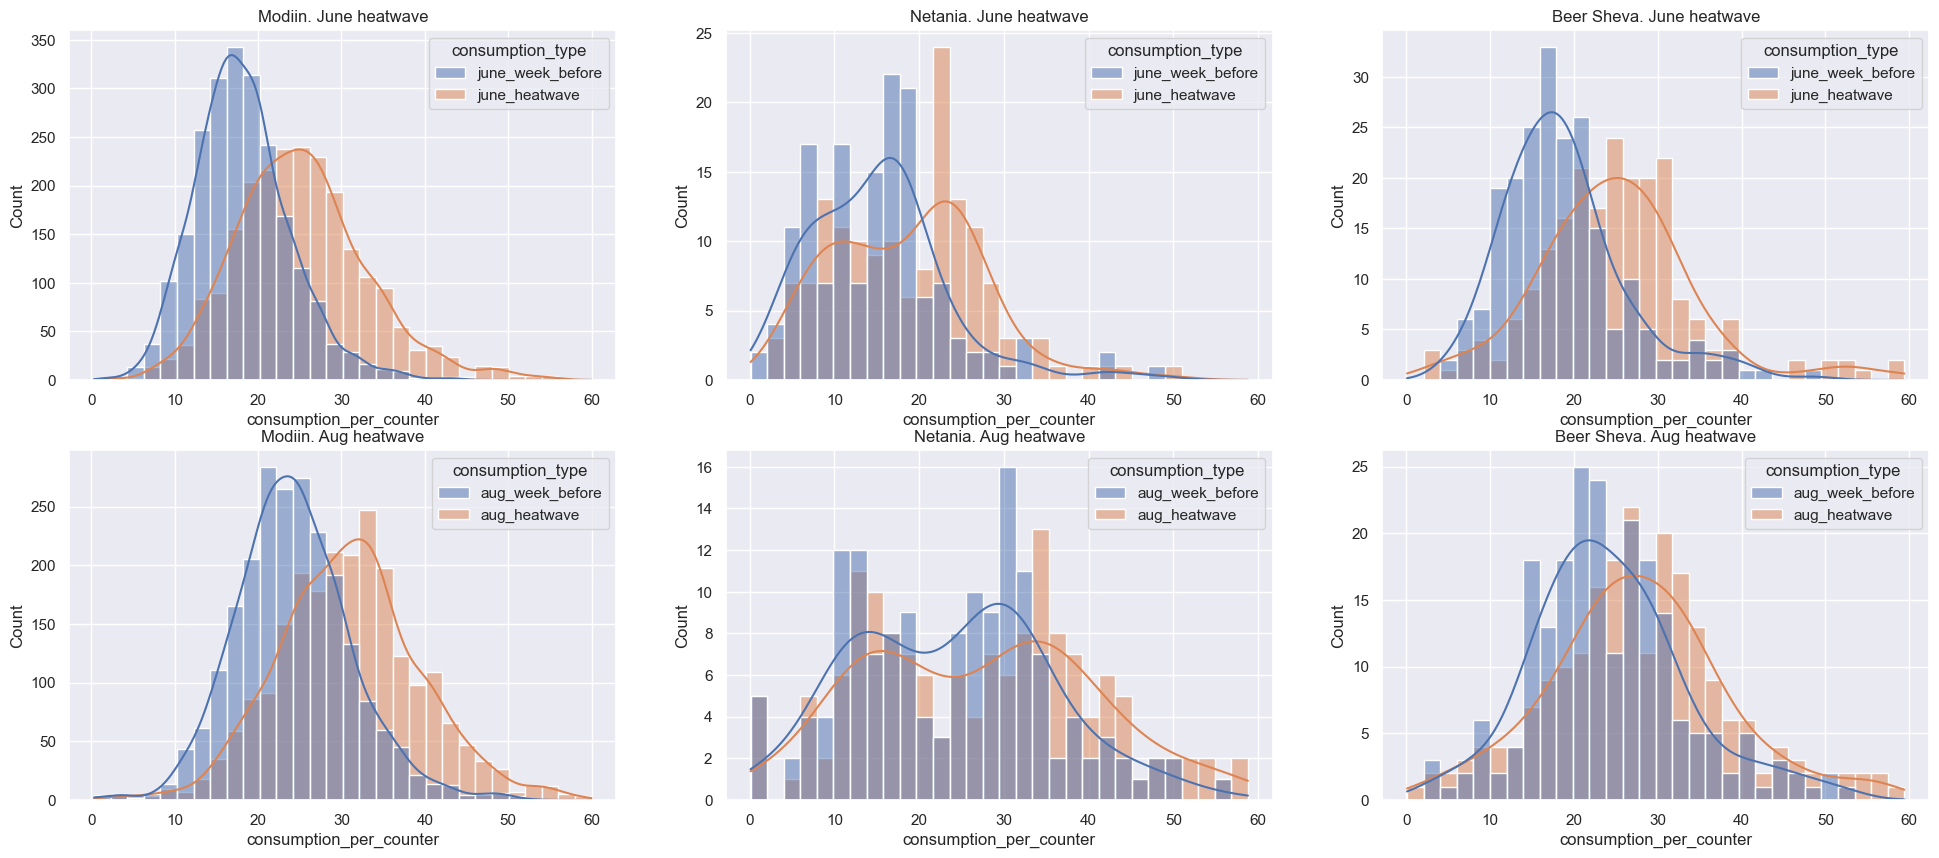

In [30]:
f, ax = plt.subplots(figsize=(24, 10), nrows=2, ncols=3)
f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][0])
f.set_title('Modiin. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][1])
f.set_title('Netania. June heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['june_week_before', 'june_heatwave'], bins=30, kde=True, ax=ax[0][2])
f.set_title('Beer Sheva. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][0])
f.set_title('Modiin. Aug heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][1])
f.set_title('Netania. Aug heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['aug_week_before', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][2])
f.set_title('Beer Sheva. Aug heatwave')

plt.savefig('hw_wrt_week_before')

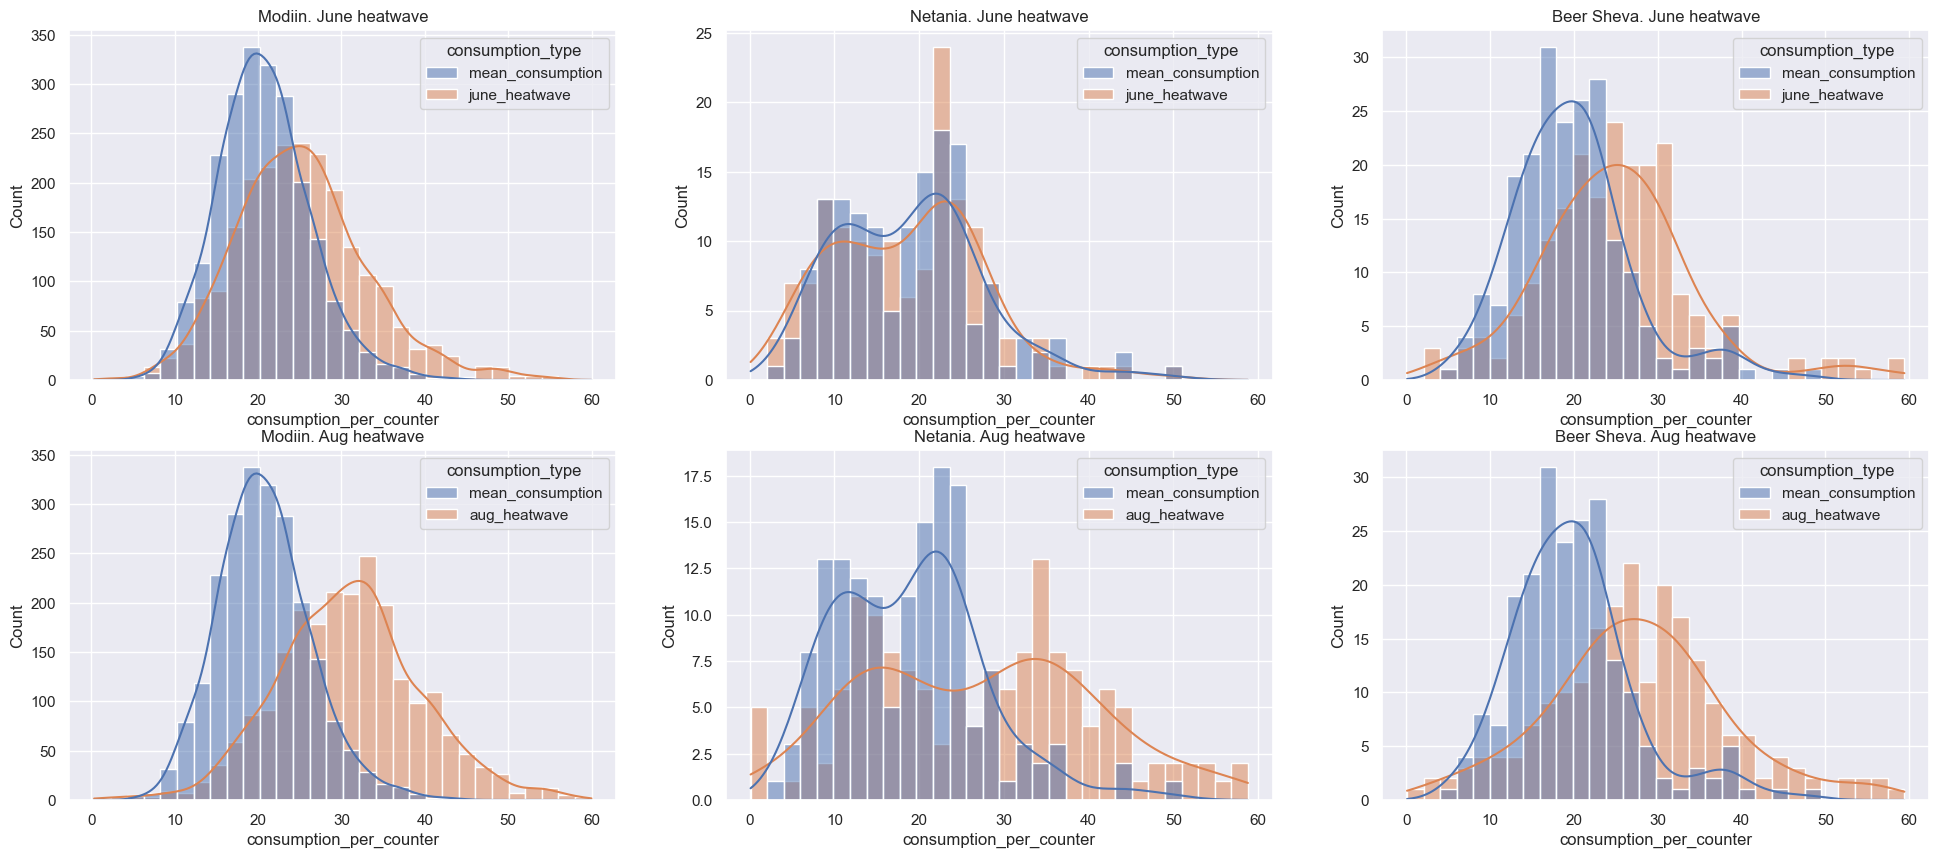

In [31]:
f, ax = plt.subplots(figsize=(24, 10), nrows=2, ncols=3)
f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][0])
f.set_title('Modiin. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][1])
f.set_title('Netania. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'june_heatwave'], bins=30, kde=True, ax=ax[0][2])
f.set_title('Beer Sheva. June heatwave')

f = sns.histplot(data=flat_df[flat_df.city == MODIIN], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][0])
f.set_title('Modiin. Aug heatwave')

f = sns.histplot(data=flat_df[flat_df.city == NETANIA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][1])
f.set_title('Netania. Aug heatwave')
f = sns.histplot(data=flat_df[flat_df.city == BEERSHEVA], x='consumption_per_counter', hue='consumption_type', hue_order=['mean_consumption', 'aug_heatwave'], bins=30, kde=True, ax=ax[1][2])
f.set_title('Beer Sheva. Aug heatwave')

plt.savefig('hw_wrt_avg')